# Project 4 - Predictive model

## 1. Load Data

In [744]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
import csv
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [723]:
#load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
weather = pd.read_csv('weather.csv')
spray = pd.read_csv('spray.csv')
#merge data (only using station 1 so as not to double the data)
trw = train.merge(weather[weather['Station']==1], how='left', on='Date')
tsw = test.merge(weather[weather['Station']==1], how='left', on='Date')
print(trw.shape, tsw.shape)

(10506, 33) (116293, 32)


In [398]:
tsw.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')

In [656]:
print(trw.shape, tsw.shape)

(10506, 33) (116293, 32)


In [256]:
#calculate baseline
trw[trw.WnvPresent == 1].shape

(551, 33)

## 2. Feature Engineering

These features didn't improve predictive scores, and were not used in the final model:

In [624]:
#unsued features (random forest crossval score didn't improve):
#
# Xtr['Lat1'] = trw.Latitude.round(1)
# Xts['Lat1'] = tsw.Latitude.round(1)

# Xtr['Long1'] = trw.Longitude.round(1)
# Xts['Long1'] = tsw.Longitude.round(1)

# Xtr['DewPoint'] = trw.DewPoint
# Xts['DewPoint'] = tsw.DewPoint

# Xtr['StnPressure'] = trw['StnPressure']
# ytr = ytr.drop(Xtr[Xtr['StnPressure']=='M'].index)
# Xtr = Xtr.drop(Xtr[Xtr['StnPressure']=='M'].index)
# Xtr['StnPressure'] = Xtr['StnPressure'].astype(float)
# Xts['StnPressure'] = tsw['StnPressure'].astype(float)
# #
# Xtr['AvgSpeed'] = trw['AvgSpeed'].astype(float)
# Xts['AvgSpeed'] = tsw['AvgSpeed'].astype(float)
#
#Xtr['PrecipTotal']= trw.PrecipTotal.apply(lambda x: 0.1 if x == 'T' else x)
#Xts['PrecipTotal']= tsw.PrecipTotal.apply(lambda x: 0.1 if x == 'T' else x)

These were the final features:

In [725]:
#get dummy variables for only for mosquito species that have Wnv 
tsw_species = pd.get_dummies(tsw['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]
trw_species = pd.get_dummies(trw['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]

In [747]:
ytr = trw.WnvPresent
print(ytr.shape)
#Build X 
Xtr = pd.DataFrame()
Xts = pd.DataFrame()
#
Xtr['Latitude'] = trw.Latitude
Xts['Latitude'] = tsw.Latitude
Xtr['Longitude'] = trw.Longitude
Xts['Longitude'] = tsw.Longitude
#
print(Xtr.shape, ytr.shape)
Xtr['Tmax'] = trw.Tmax.astype(float)
Xts['Tmax'] = tsw.Tmax.astype(float)
#
Xtr['CULEX PIPIENS/RESTUANS'] = trw_species['CULEX PIPIENS/RESTUANS']
Xts['CULEX PIPIENS/RESTUANS'] = tsw_species['CULEX PIPIENS/RESTUANS']
Xtr['CULEX PIPIENS'] = trw_species['CULEX PIPIENS']
Xts['CULEX PIPIENS'] = tsw_species['CULEX PIPIENS']
Xtr['CULEX RESTUANS'] = trw_species['CULEX RESTUANS']
Xts['CULEX RESTUANS'] = tsw_species['CULEX RESTUANS']
#
Xtr['DayOfYear'] = pd.to_datetime(trw['Date'], format='%Y-%m-%d').dt.dayofyear
Xts['DayOfYear'] = pd.to_datetime(tsw['Date'], format='%Y-%m-%d').dt.dayofyear
#
Xtr['WetBulb'] = trw.WetBulb
ytr = ytr.drop(Xtr[Xtr['WetBulb']=='M'].index)
Xtr = Xtr.drop(Xtr[Xtr['WetBulb']=='M'].index)
Xtr['WetBulb'] = Xtr['WetBulb'].astype(float)
Xts['WetBulb'] = tsw.WetBulb.astype(float)                   #didn't have any 'M values
#
Xtr['Tmin'] = trw['Tmin'].astype(float)
Xts['Tmin'] = tsw['Tmin'].astype(float)


print(Xtr.shape, ytr.shape)
print(Xts.shape)

(10506,)
(10506, 2) (10506,)
(10413, 9) (10413,)
(116293, 9)


In [473]:
#check dtypes
#print(Xtr.dtypes)
#print(ytr.dtypes)

In [474]:
#check for nulls
#print(Xtr.isnull().sum())
#print(Xts.isnull().sum())

We tried oversampling the WnvPresent observations, but it didn't make any difference

In [715]:
#since classes are unbalanced, oversample WnvPresent = 1
#trw = trw.append(trw[trw.WnvPresent==1])   #didn't make any difference

# 3. Build Models

Each of these models were gird searched manually to find the best hyper-parameters, then the best scoring output were submitted to Kaggle

In [ ]:
###############Sklearn models

### 3.1 AdaBoost

In [752]:
####### ADABoost model
model = AdaBoostClassifier(n_estimators=100) 
scores = cross_val_score(model, Xtr, ytr, cv=3)
print(scores)
print(np.mean(scores))

[0.8485023  0.94698934 0.68184438]
0.8257786749328969


### 3.2 Random Forest

In [751]:
#######RANDOM FOREST model
model = RandomForestClassifier(max_features = 6, max_depth = 20) 
scores = cross_val_score(model, Xtr, ytr, cv=3)
print(scores)
print(np.mean(scores))

[0.7390553  0.94641314 0.45590778]
0.7137920726477903


### 3.3 Gradient Boosting

In [735]:
#######GRADIENT BOOSTING model
model = GradientBoostingClassifier(max_features = 6, max_depth = 100) 
scores = cross_val_score(model, Xtr, ytr, cv=3)
print(scores)
print(np.mean(scores))

[0.58006912 0.94237972 0.44553314]
0.6559939944316514


Re-fit the best performing model (AdaBoost)

In [753]:
#fit against full training set (printed below are AdaBoost results)
model.fit(Xtr,ytr)
model.score(Xtr,ytr)

0.9470853740516662

In [754]:
#metrics.roc_auc_score(ytr,y_preds)
y_preds = model.predict_proba(Xtr)[:,1]
metrics.roc_auc_score(ytr,y_preds)

0.8540811474206114

### 3.4 Keras

In [704]:
#Create keras Model
X_train, X_test, y_train, y_test = train_test_split(Xtr, ytr, test_size=0.30, random_state=11)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)  #the scaler is fit only to the training data
X_test = ss.transform(X_test)

model = Sequential()

input_units = X_train.shape[1] #number of features in training set
hidden_units = input_units   #hidden layer has the same number of nodes as input

#first input layer
model.add(Dense(hidden_units            
                ,input_dim=input_units  
                ,activation='relu'
                #uncomment this to add L2 regularization
                #,kernel_regularizer=regularizers.l2(0.0001) 
               ))


#hidden layer (try with and without)
node_reduction = 0
model.add(Dense(hidden_units - node_reduction          
                ,input_dim=input_units  
                ,activation='relu'
                #,kernel_regularizer=regularizers.l2(0.0001) 
               ))
#model.add(Dropout(0.8))

#final layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy'
              ,optimizer='adam'
               #added later (not part of original solution
              ,metrics=['binary_accuracy']
             )

(7289, 8) (7289,)
(3124, 8) (3124,)


In [706]:
#Run Keras model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
               epochs=20, batch_size=None, verbose=1)

Train on 7289 samples, validate on 3124 samples
Epoch 1/20
7289/7289 [==============================] - 1s 197us/step - loss: 0.7301 - binary_accuracy: 0.6238 - val_loss: 0.3361 - val_binary_accuracy: 0.9494
Epoch 2/20
7289/7289 [==============================] - 0s 55us/step - loss: 0.2650 - binary_accuracy: 0.9461 - val_loss: 0.2157 - val_binary_accuracy: 0.9494
Epoch 3/20
7289/7289 [==============================] - 0s 55us/step - loss: 0.2145 - binary_accuracy: 0.9461 - val_loss: 0.1972 - val_binary_accuracy: 0.9494
Epoch 4/20
7289/7289 [==============================] - 0s 55us/step - loss: 0.2049 - binary_accuracy: 0.9461 - val_loss: 0.1918 - val_binary_accuracy: 0.9494
Epoch 5/20
7289/7289 [==============================] - 0s 55us/step - loss: 0.2009 - binary_accuracy: 0.9461 - val_loss: 0.1888 - val_binary_accuracy: 0.9494
Epoch 6/20
7289/7289 [==============================] - 0s 54us/step - loss: 0.1987 - binary_accuracy: 0.9461 - val_loss: 0.1871 - val_binary_accuracy: 0.94

## 4. Kaggle Submission

In [694]:
#run model against the kaggle test dataset
test_preds = model.predict_proba(Xts)[:,1]

In [707]:
#for keras only
test_preds = model.predict_proba(Xts)
test_preds = test_preds[:,0]

In [545]:
#metrics.roc_auc_score(yts,test_preds)

In [756]:
#generate output file 
test_preds = model.predict_proba(Xts)[:,1]
output_file = pd.DataFrame({'Id':tsw.Id, 'WnvPresent':test_preds})  
#output_file.head()
csv_name = 'test_csv.csv'
output_file.to_csv(csv_name, index=False)
print(output_file.shape)

(116293, 2)


## Kaggle Score for Adaboost Model: .72455 



## 5. Feature Importance

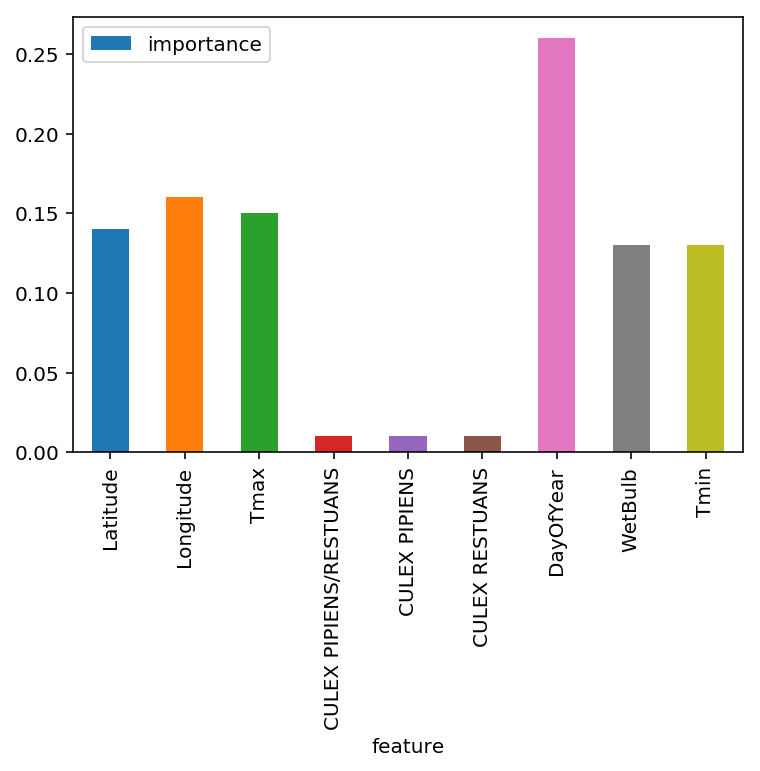

In [755]:
features = pd.DataFrame(list(zip(Xtr.columns,model.feature_importances_))
                        ,columns=['feature','importance']) 

features.plot(kind='bar', x='feature', y='importance')
plt.xticks(rotation = 90)
plt.title = 'Model Feature Importance'

In [742]:
features

,feature,importance
0,Latitude,0.11
1,Longitude,0.13
2,Tmax,0.17
3,CULEX PIPIENS/RESTUANS,0.01
4,CULEX PIPIENS,0.01
5,CULEX RESTUANS,0.01
6,DayOfYear,0.37
7,WetBulb,0.19


## 6. Discussion

The training scores and Kaggle submission scores correlated fairly well, although
the Kaggle submission score usually about a tenth of a point lower. This is an indication
that model results probably have some validity.

The lack of number of mosquitos per trap and spraying data for the test years was a limitation.
If this data were present, it could be inlcuded in the model and would likely lead to better
results.

Day of Year ended up being the best predictor - the interesting question is why. Most likely,
it serves as a proxy for cumulative weather conditions. 

Possible ways of improving the model: include features for cumulative weather conditions; 
these could include average temperature over the past week, average precipitation over the
past week, and number of days without preciptiation.
